# FoDS Project: Covid 

## 1 Preparation

### Structure 
1. Setting up the environment
2. Importing the data

### 1. Environment
1. python == 3.11.8 
2. matplotlib=3.8.3
3. numpy=1.26.0
4. pandas=2.1.1
5. scipy=1.12.0
6. seaborn=0.13.2
7. sklearn=1.4.2

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from scipy.stats import boxcox
import warnings
warnings.filterwarnings("ignore")

### 2. Importing Data

In [ ]:
data = pd.read_csv("../data/OWID-covid-data-28Feb2023.csv")
df = data

## 2 Getting an overview

### Structure
1. Basic overview
2. Datatypes
3. Locations and continents

### 1. Basic overview

In [ ]:
print(data.info())

In [ ]:
print(data.describe())

In [ ]:
print(data.head())

In [ ]:
print(data.tail())

In [ ]:
print("Number of observations:", data.shape[0])
print("Number of columns:", data.shape[1])

### 2. Datatypes

#### 2.1 All datatypes

In [ ]:
#Datatypes of each variable:
print(data.dtypes)

#### 2.2 Integers

In [ ]:
int_data = data.select_dtypes(include=("int64")).columns
print("INTEGERS: ", int_data)

It seems we do not have any integers in our data. (We have but they are just not saved as such)

#### 2.3 Floats

In [ ]:
float_data = data.select_dtypes(include=("float64")).columns
print("FLOATS: ", float_data)

#### 2.4 Objects

In [ ]:
object_data = data.select_dtypes(include=("object")).columns
print("OBJECTS:", object_data)
num_data = data[float_data] 

#### 2.5 Saving numerical and categorical data in seperate data frames

In [ ]:
num_data = data[float_data] 
cat_data = data[object_data]

#### 2.6 Adjusting date datatype

In [ ]:
data["date"] = pd.to_datetime(data["date"])

## 3 Introductory Visualizations

### Structure
1. Cases Visualized
2. Deaths Visualized

### 1. Cases Visualized

#### 1.1 Cases per day

In [ ]:
# Problem: Most countries did not publish covid numbers on the weekends
# Effect: This leads to an oscillating graph for daily new cases
# This can be solved with weekly new cases
# either extract data from new_daily or use the smoothed cases count
daily_cases = data.groupby('date')['new_cases'].sum()
data_march= data[(data['date']>'2022-03-01')&(data['date']<'2022-04-01')]
daily_cases_march = data_march.groupby('date')['new_cases'].sum()
daily_cases_weekly= data.groupby(pd.Grouper(key='date', freq='W')).sum()['new_cases']

# Plotting
fig, (ax1,ax2,ax3, ax4)=plt.subplots(4,1,figsize=(10,20))
ax1.plot(daily_cases, label='New Cases Per Day')
ax1.set(title='COVID-19 New Cases Per Day',
        xlabel='Date',
        ylabel='Number of New Cases'
        )
ax1.legend()
ax2.plot(daily_cases_march, label='New Cases Per Day, March 2022')
ax2.set(title='COVID-19 New Cases Per Day',
        xlabel='Date',
        ylabel='Number of New Cases'
        )
ax2.legend()
ax3.plot(daily_cases_weekly, label='New Cases Per Day, Daily turned to weekly')
ax3.set(title='COVID-19 New Cases Per Day',
        xlabel='Date',
        ylabel='Number of New Cases'
        )

ax3.legend()
ax4.plot(data.groupby('date')['new_cases_smoothed'].sum(), label='New Cases Per Day, Daily turned to weekly')
ax4.set(title='COVID-19 New Cases Per Day',
        xlabel='Date',
        ylabel='Number of New Cases'
        )

ax4.legend()
plt.subplots_adjust(hspace=0.5)
plt.savefig('../output/Introductory_Visualizations/Cases/newcasestotal.png')


#### 1.2 Cases over time by continent compact

In [ ]:
grouped_data = data[~(data['continent']==0)].groupby(['date', 'continent'])['new_cases_smoothed'].sum().reset_index()
plt.figure(figsize=(12, 8))
sns.lineplot(x='date', y='new_cases_smoothed', hue='continent', data=grouped_data)
plt.title('New COVID-19 Cases by Continent Over Time')
plt.xlabel('Date')
plt.ylabel('Number of New Cases')
plt.legend(title='Continent')
plt.grid(True)  
plt.savefig('../output/Introductory_Visualizations/Cases/newcasesbycontinent')

#### 1.3 Cases over time by continent in subplots

In [ ]:
grouped_data = data[~(data['continent']==0)].groupby(['continent','date'])['new_cases_smoothed'].sum().reset_index()
continents_of_interest=['North America','South America','Asia','Europe','Oceania','Africa']
fig, axs = plt.subplots(1,6,figsize=(24,8), sharey=True)
for i,continent in enumerate(continents_of_interest):
        sns.lineplot(x='date', y='new_cases_smoothed',  data=grouped_data[grouped_data['continent']==continent],ax=axs[i])
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('New Cases')
        axs[i].set_title(continent)
        axs[i].tick_params(axis='x', rotation=90)
        axs[i].grid(True)
plt.suptitle('New Cases by Continent')
plt.savefig('../output/Introductory_Visualizations/Cases/casesbycontinentsp')


#### 1.4 Total cases vs total cases per million by continent

In [ ]:
cases=['total_cases','total_cases_per_million']
fig, axs= plt.subplots(2,1,figsize=(10,10))
data_nozero=data[~(data['continent']==0)]
for i, variable in enumerate(cases):
        top_countries = data_nozero.groupby('continent')[variable].max().nlargest(10)
        print(top_countries)
        top_countries.plot(kind='bar', ax=axs[i],grid=True)
        axs[i].set_xlabel('Continent')
        axs[i].set_ylabel(variable)
plt.suptitle('Total Cases vs Total Cases per Million')
plt.subplots_adjust(hspace=0.5)
plt.savefig('../output/Introductory_Visualizations/Cases/casesbycontinent.png')

#### 1.5 Total cases vs total cases per million by country

In [ ]:
cases=['total_cases','total_cases_per_million']
fig, axs= plt.subplots(2,1,figsize=(10,10))
data_noowid=data[~data['iso_code'].str.startswith("OWID_")]
for i, variable in enumerate(cases):
        top_countries = data_noowid.groupby('iso_code')[variable].max().nlargest(10)
        print(top_countries)
        top_countries.plot(kind='bar', ax=axs[i],grid=True)
        axs[i].set_xlabel('Country')
        axs[i].set_ylabel(variable)
plt.suptitle('Total Cases vs Total Cases per Million')
plt.subplots_adjust(hspace=0.5)
plt.savefig('../output/Introductory_Visualizations/Cases/casesbycountry.png')

#### 1.6 Scatter plots with variables of interest to see correlation with total cases

In [ ]:
variables_of_interest = [
    'icu_patients_per_million', 'total_tests_per_thousand', 'total_vaccinations_per_hundred',
    'stringency_index', 'hospital_beds_per_thousand', 'aged_65_older'
]
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.flatten()
for i, variable in enumerate(variables_of_interest):
    sns.scatterplot(x=variable, y='total_cases_per_million', data=data, ax=axs[i], markers='.')
    axs[i].set_title(f'Total Cases per Million vs. {variable}')
    axs[i].set_xlabel(variable)
    axs[i].set_ylabel('Total Cases per Million')
plt.tight_layout()
plt.savefig('../output/Introductory_Visualizations/Cases/totcasescorr.png')

### 2. Deaths visualized

#### 2.1 New deaths

In [ ]:
daily_deaths = data.groupby('date')['new_deaths'].sum()
daily_deaths_smoothed = data.groupby('date')['new_deaths_smoothed'].sum()

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,20))

ax1.plot(daily_deaths, label='New Deaths Per Day')
ax1.set(title='COVID-19 New Deaths Per Day', xlabel='Date', ylabel='Number of New Deaths')
ax1.legend()

ax2.plot(daily_deaths_smoothed, label='New Deaths Per Day, Smoothed Data')
ax2.set(title='COVID-19 New Deaths Per Day', xlabel='Date', ylabel='Number of New Deaths')
ax2.legend()

plt.savefig("../output/Introductory_Visualizations/Deaths/new_deaths.png")

Trying to find out if there is a difference in deaths per million among the continents.

In [ ]:
new_deaths_per_million_continent = data.groupby(['date', 'continent'])['new_deaths_per_million'].sum().reset_index()
new_deaths_per_million_continent_smoothed = data.groupby(['date', 'continent'])['new_deaths_smoothed_per_million'].sum().reset_index()
total_cases_per_continent = data.groupby(['date', 'continent'])['total_cases_per_million'].sum().reset_index()
print(new_deaths_per_million_continent)
print(new_deaths_per_million_continent_smoothed)

#### 2.2 New deaths per million by continent

In [ ]:
continents_deaths = new_deaths_per_million_continent['continent'].unique()
#Creating suplots per Continent with the real counts
fig, axes = plt.subplots(len(continents_deaths), 1, figsize=(10, 6*len(continents_deaths)), sharex=True)
# Iterate over each continent and create a subplot
for i, continent in enumerate(continents_deaths):
    continent_data = new_deaths_per_million_continent[new_deaths_per_million_continent['continent'] == continent]
    sns.lineplot(data=continent_data, x='date', y='new_deaths_per_million', ax=axes[i])
    axes[i].set_title(f'New Deaths per Million in {continent} Over Time')
    axes[i].set_ylabel('New Deaths per Million')
    axes[i].set_xlabel('Date')
    axes[i].grid(True)
    
plt.tight_layout()

plt.savefig("../output/Introductory_Visualizations/Deaths/NewDeathsPerMillion_Subplots.png")


#### 2.3 Smoothed new deaths per million by continent

In [ ]:
fig, axes = plt.subplots(len(continents_deaths), 1, figsize=(10, 6*len(continents_deaths)), sharex=True)

for i, continent in enumerate(continents_deaths):
    continent_data = new_deaths_per_million_continent_smoothed[new_deaths_per_million_continent_smoothed['continent'] == continent]
    sns.lineplot(data=continent_data, x='date', y='new_deaths_smoothed_per_million', ax=axes[i])
    axes[i].set_title(f'New Deaths per Million in {continent} Over Time')
    axes[i].set_ylabel('New Deaths per Million')
    axes[i].set_xlabel('Date')
    axes[i].grid(True)
    
plt.tight_layout()

plt.savefig("../output/Introductory_Visualizations/Deaths/NewDeathsPerMillionSmoothed_Subplots.png")

#### 2.4 New deaths per million divided by total cases

Trying to make a statement about the severity by analyzing the new deaths per million divided by the total cases.
Merge the new deaths and total cases. Calculate new deaths per million divided by total cases per million.

In [ ]:
death_cases_merge = pd.merge(new_deaths_per_million_continent_smoothed, total_cases_per_continent, on=['date', 'continent'])
death_cases_merge['deaths_to_cases_ratio'] = death_cases_merge['new_deaths_smoothed_per_million'] / death_cases_merge['total_cases_per_million']


fig, axes = plt.subplots(len(continents_deaths), 1, figsize=(10, 6*len(continents_deaths)), sharex=True)

for i, continent in enumerate(continents_deaths):
    continent_data = death_cases_merge[death_cases_merge['continent'] == continent]
    sns.lineplot(data=continent_data, x='date', y='deaths_to_cases_ratio', ax=axes[i])
    axes[i].set_title(f'New Deaths per Million divided by Total Cases per Million in {continent} Over Time')
    axes[i].set_ylabel('New Deaths per Million / Total Cases per Million')
    axes[i].set_xlabel('Date')
    axes[i].grid(True)
    
plt.tight_layout()

plt.savefig("../output/Introductory_Visualizations/Deaths/NewDeathsToCasesRatio_Subplots.png")

## 4 Missing Data Analysis


### Structure


1. Introductory remarks about OWID
2. Preparatory steps
3. First overview of missing data
4. Overview missing data "cases" and "deaths"
5. Total cases continent analysis
6. Factual accuracy
7. Country analysis


### 1. Introductory remarks about OWID

OWID itself states that it generally takes its data from 4 different sources:
1. Specialized institutes
2. Research articles
3. International Institutations or statistics agencies
4. Official data from government sources

More specifically, looking at the OWID COVID dataset online where all the sources are indicated, it can be seen that OWID takes most of the data directly from the WHO COVID dashboard and then completes it with other sources which is why this dataset can be expected to be quite complete. However, the following analysis is attempting to analyze how much data is missing from the dataset and what kind of data is missing. 

### 2. Preparatory steps

#### 2.1 Adjusting visualization settings

In [ ]:
# Define colorblind-friendly palette
color_palette = sns.color_palette("colorblind")

In [ ]:
#adjusting the viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### 2.2 Data Cleaning


In [ ]:
#dropping duplicates
data = data.drop_duplicates()

#separating OWID from non_OWID data
data_without_OWID = data[~data['iso_code'].str.contains('OWID')]
data_OWID = data[data['iso_code'].str.contains('OWID')]

What OWID contains:

In [ ]:
grouped_OWID_loc = data_OWID.groupby("location")
loc_OWID = list(grouped_OWID_loc.groups.keys())
print(loc_OWID)

OWID contains a few extra metrics and countries/continents or composites of such.

### 3. First overview of missing data

#### 3.1 Entries with complete information

In [ ]:
#For how many entries do we have complete information?
(data.isna().sum(axis=1) == 0).sum()

#### 3.2 Missing values per column overall

In [ ]:
#missing values overall per column
total_missing = data.isnull().sum()
total_missing_percentage = (total_missing / len(data)) * 100
total_missing_sorted = total_missing.sort_values()
total_missing_percentage_sorted = total_missing_percentage.sort_values()

In [ ]:
#graphing the missing values per column
plt.figure(figsize=(6, 8))
fig_mv_variables = sns.barplot(
    x = total_missing_percentage_sorted.values,
    y = total_missing_percentage_sorted.index
)
fig_mv_variables.set(
    title="Missing values per variable",
    xlabel="Percentage of Missing Values",
    ylabel="Variables"
)
plt.savefig("../output/Missing_Data_Analysis/missing_data.png", bbox_inches="tight")              

### 4. Overview missing data "cases" and "deaths"

#### 4.1 Selecting only the columns containing information about cases and deaths

In [ ]:
#selecting the columns about cases of interest
columns_about_cases = data.loc[:, data.columns.str.contains('cases')]
columns_about_cases.columns

In [ ]:
columns_about_deaths = data.loc[:, data.columns.str.contains('death')]
columns_about_deaths.columns

#### 4.2 Sorting and plotting overall missing data about cases

In [ ]:
def missing_data_filtered(columns_of_interest):
    total_missing = columns_of_interest.isnull().sum()
    total_missing_percentage = (total_missing / len(data)) * 100
    total_missing_sorted = total_missing.sort_values()
    total_missing_percentage_sorted = total_missing_percentage.sort_values()
    return total_missing_percentage_sorted

total_missing_percentage_deaths_sorted = missing_data_filtered(columns_about_deaths)

In [ ]:
plt.figure(figsize=(4, 3))
deaths_overview = sns.barplot(
    x = total_missing_percentage_deaths_sorted.values,
    y = total_missing_percentage_deaths_sorted.index
)
deaths_overview.set(
    title="Missing values per variable",
    xlabel="Percentage of Missing Values",
    ylabel="Variables"
)
plt.savefig("../output/Missing_Data_Analysis/deathsmissing_data.png", bbox_inches="tight")  

#### 4.3 Sorting and plotting overall missing data about deaths

In [ ]:
total_missing_percentage_cases_sorted = missing_data_filtered(columns_about_cases)

In [ ]:
plt.figure(figsize=(4, 3))
cases_overview = sns.barplot(
    x = total_missing_percentage_cases_sorted.values,
    y = total_missing_percentage_cases_sorted.index
)
cases_overview.set(
    title="Missing values per variable",
    xlabel="Percentage of Missing Values",
    ylabel="Variables"
)
plt.savefig("../output/Missing_Data_Analysis/casesmissing_data.png", bbox_inches="tight") 

There is in the overall dataset a lot more data around cases than deaths. However, amongst the columns that give information about either death or cases, the variability as to the amount of missing data is low.

### 5 Total cases continent analysis


#### 5.1 Amount of data per country

Comment: Since reporting is generally done on a national level, it makes sense to have a look at individual countries to find out where potential data is missing.

In [ ]:
#how many countries are we dealing with overall
unique_values_world = data_without_OWID['iso_code'].unique()
print (len(unique_values_world))

In [ ]:
#calculating the number of entries for each country
length_list = []
length_list_in_years = []

for i in range(len(unique_values_world)):
    country = unique_values_world[i]
    length_country = len(data_without_OWID.loc[df['iso_code'] == country])
    length_list.append(length_country)
    length_list_in_years.append(length_country/365)

sorted_country_length = sorted(length_list)

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(length_list_in_years, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('data points converted to number of years')
plt.ylabel('number of countries')
plt.title("Number of entries in the data set per country")
plt.show()

#### 5.2 Total cases Asia


In [ ]:
#different continents
filtered_continents = data_without_OWID["continent"].unique()
filtered_continents

In [ ]:
#function returning list of all different countries on one continent
def countries_per_continent(continent):
    filtered_continent = data_without_OWID.loc[df['continent'] == continent]
    unique_values_continent = filtered_continent['iso_code'].unique()
    return unique_values_continent

unique_values_Asia = countries_per_continent("Asia")
unique_values_Asia

In [ ]:
def continent_values(continent_uniq_val):
    values = []
    for i in range(len(continent_uniq_val)):
        currentcountry = continent_uniq_val[i]
        filtered_country = data.loc[df['iso_code'] == currentcountry]
        no_rows_current_country = len(filtered_country)
        missing = (filtered_country["total_cases"].isnull().sum())
        total_missing_percentage_current_country = (missing / len(filtered_country)) * 100
        values.append(total_missing_percentage_current_country)
    return values

values_Asia = continent_values(unique_values_Asia)

In [ ]:
def plotting_barplot_continent (unique_codes, values):
    plt.figure(figsize=(26, 8))
    missing_values_Asia = sns.barplot(
        x = unique_codes,
        y = values
    )

    deaths_overview.set(
        title="Missing values per variable",
        xlabel="Percentage of Missing Values",
        ylabel="Variables"
    )

    plt.savefig("../output/Missing_Data_Analysis/casesmissing_data2.png", bbox_inches="tight") 

plotting_barplot_continent(unique_values_Asia, values_Asia)

#### 5.3 Total Cases Europe

In [ ]:
unique_values_Europe = countries_per_continent("Europe")
unique_values_Europe

In [ ]:
values_Europe = continent_values(unique_values_Europe)

In [ ]:
plotting_barplot_continent(unique_values_Europe, values_Europe)

#### 5.4 Total Cases Africa

In [ ]:
unique_values_Africa = countries_per_continent("Africa")
unique_values_Africa

In [ ]:
values_Africa = continent_values(unique_values_Africa)

In [ ]:
plotting_barplot_continent(unique_values_Africa, values_Africa)

#### 5.5 Total Cases North America

In [ ]:
unique_values_North_America = countries_per_continent("North America")
unique_values_North_America

In [ ]:
values_North_America = continent_values(unique_values_North_America)

In [ ]:
plotting_barplot_continent(unique_values_North_America, values_North_America)

### 6. Factual accuracy

#### 6.1 Do total cases and new cases lead to the same numbers?

Looking at Canada the reporting started on 23 of January but the first death was on March 9. A quick search on the internet confirms that 9 March was the date on which the frist Canadian person died. That makes 46 days on which there is no data on deaths. But there are 1132 entries for Canada and hence 46/1132 = 4%. In the case of Switzerland 10 no values for deaths and 1099 rows so that would make 1% of the data missing. For Germany 42/1128 = 4%. All of this data is not missing, it is just wrongly classified as NA when these should be zero.

In [ ]:
def comparison_total_new_cases(country): 
    filtered_country = data_without_OWID.loc[df["location"] == "Sweden"]
    filtered_country_total_cases_from_tc = filtered_country.iloc[-1, 4]
    print ("total cases from the total cases column: ", filtered_country_total_cases_from_tc)
    print ("total cases when summing over new cases: ", filtered_country["new_cases"].sum())

comparison_total_new_cases("Sweden")

#### 6.2 How accurate are vaccination statistics?

According to Wikipedia, the first vaccination in Switzerland, Germany and France tool place on December 23 2020, December 22, 2020 and December 17, 2020 respectively. The dataset confirms these:

In [ ]:
def first_vaccination_statistics_accuracy(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    filtered_country = filtered_country.reset_index(drop=True)
    first_vaccination_index = filtered_country["total_vaccinations"].first_valid_index()
    return filtered_country.iloc[first_vaccination_index,:5]
    
first_vaccination_statistics_accuracy("France")

### 7. Country analysis

#### 7.1 Function to replace missing data with zeros

In [ ]:
#here is how to replace the mssing values with zero values
def replace_missing_data(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    filtered_country = filtered_Italy.reset_index(drop=True)
    missing_vals = ["NA", "", None, np.NaN]
    missing_country = filtered_country.isin(missing_vals)


#### 7.2 Function for missing values excluding missing at the end and at the beginning for a specific country

In [ ]:
def filtering_missing_country(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    filtered_country = filtered_country.reset_index(drop=True)
    filtered_country_summary = filtered_country.isnull().sum()
    first_valid_indices_country = filtered_country.apply(lambda x: x.first_valid_index())
    last_valid_indices_country = filtered_country.apply(lambda x: x.last_valid_index())
    length = len(filtered_country) - 1

    filtered_country_summary_df = filtered_country_summary.to_frame()
    first_valid_indices_country_df = first_valid_indices_country.to_frame()
    last_valid_indices_country_df = last_valid_indices_country.to_frame()
    list_of_dataframes = [filtered_country_summary_df, first_valid_indices_country_df, last_valid_indices_country]

    comparison_country = pd.merge(filtered_country_summary_df, first_valid_indices_country_df, left_index=True, right_index=True)
    comparison_country = comparison_country.rename(columns={"0_x": '# of missing entries', "0_y": "first entry"})
    diff_first = filtered_country_summary_df - first_valid_indices_country_df
    last_valid_indices_country_df_diff = length - last_valid_indices_country_df
    diff_overall = filtered_country_summary_df - first_valid_indices_country_df - last_valid_indices_country_df_diff
    comparison_country = comparison_country.assign(diff_first = diff_first, \
                last_entry= last_valid_indices_country_df, diff_last = last_valid_indices_country_df_diff, \
                diff_overall = diff_overall)
    return (comparison_country)

In [ ]:
filtering_missing_country("Finland")

#### 7.3 Function total diff for many countries

In [ ]:
def locations_per_continent(continent):
    filtered_continent = data_without_OWID.loc[df['continent'] == continent]
    unique_values_continent = filtered_continent['location'].unique()
    return unique_values_continent

In [ ]:
unique_locations_Europe = locations_per_continent("Europe")
empty_df = pd.DataFrame()

def several_countries(list, dataframe):
    count = 0
    for i in (list):
        country = filtering_missing_country(i)
        #print (country)
        country_diff_overall_column = country["diff_overall"]
        #print (country_diff_overall_column)
        country_diff_overall_column_df = country_diff_overall_column.to_frame()
        if count == 0:
            combined_df = pd.concat([empty_df, country_diff_overall_column_df], axis=1)
            count = 1
        elif count > 0:
            combined_df = pd.concat([combined_df, country_diff_overall_column_df], axis=1)
        #print (country_diff_overall_column_df)
        combined_df = combined_df.rename(columns={'diff_overall': i})
    return (combined_df)

several_countries(unique_locations_Europe, empty_df)

In [ ]:
country_of_interest = "Finland"
filtered = data_without_OWID.loc[df['location'] == country_of_interest]
filtered = filtered.reset_index(drop=True)
vaccinations = filtered["total_vaccinations"]
vaccinations.head(500)

Finland and other countries only reporting once per week

## 5 Handling of missing data

### Structure
1. Decision to delete columns 63:67
2. Decision over keeping or deleting/imputing columns 0:16 (Nico)
3. Decision over keeping or deleting/imputing columns 16:32 (Leon)
4. Decision over keeping or deleting/imputing columns 32:48 (Florin)
5. Decision over keeping or deleting/imputing columns 48:63 (Sevi)
6. Actual imputations and deletions

### 1. Decision to delete columns 63:67

### 2. Decision over keeping or deleting/imputing columns 0:16 (Nico)

### 3. Decision over keeping or deleting/imputing columns 16:32 (Leon)

### 4. Decision over keeping or deleting/imputing columns 32:48 (Florin)

### 5. Decision over keeping or deleting/imputing columns 48:63 (Sevi)

### 6. Actual imputations and deletions

## 6 Data preprocessing (Handling of missing data excluded) 

### Structure
1. Looking for outliers
2. Distribution of data
3. Scaling

### 1. Looking for outliers

In [1056]:
summary_stats = data.describe()
Q1 = summary_stats.loc['25%']
Q3 = summary_stats.loc['75%']
IQR = Q3 - Q1
# Define outliers using IQR rule
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Align DataFrame columns with summary statistics columns
data, lower_bound = data.align(lower_bound, axis=1, join='inner')
data, upper_bound = data.align(upper_bound, axis=1, join='inner')
outliers = data[(data < lower_bound) | (data > upper_bound)].dropna(axis=1, how='all')
if not outliers.empty:
    print("Outliers:")
    print(outliers)
else:
    print("No outliers found.")

Outliers:
        total_cases  new_cases  new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  total_cases_per_million  new_cases_per_million  new_cases_smoothed_per_million  total_deaths_per_million  new_deaths_per_million  new_deaths_smoothed_per_million  reproduction_rate  icu_patients  icu_patients_per_million  hosp_patients  hosp_patients_per_million  weekly_icu_admissions  weekly_icu_admissions_per_million  weekly_hosp_admissions  weekly_hosp_admissions_per_million  total_tests  new_tests  total_tests_per_thousand  new_tests_per_thousand  new_tests_smoothed  new_tests_smoothed_per_thousand  positive_rate  tests_per_case  total_vaccinations  people_vaccinated  people_fully_vaccinated  total_boosters  new_vaccinations  new_vaccinations_smoothed  total_vaccinations_per_hundred  total_boosters_per_hundred  new_vaccinations_smoothed_per_million  new_people_vaccinated_smoothed  new_people_vaccinated_smoothed_per_hundred  population_density  gdp_per_capita  extreme_poverty

### 2. Distribution of data 

#### 2.1 Distribution of numercial data

Testing whether the data is normally distributed or not:
Using the anderson darling test, since the shapiro wilks is not suitable for data n > 5000 

In [1058]:
distribution_results = {}
for column in num_data.columns:
    result = sts.anderson(num_data[column].dropna(), dist='norm')  ############################### I had to drop all na for it to work!!! -> maybe imputation needed
    test_stat = result.statistic 
    critical_val = result.critical_values
    #print(critical_val)                                
    #print(test_stat)                           
    if test_stat > critical_val[2]:
        result = "not normal"
    else:
        result = "normal"    
    distribution_results[column] = result


not_normal = []
for key, value in distribution_results.items():
    if value == "not normal":
        not_normal.append(key)
if len(not_normal) == 0:
    print("All numerical data seems to be normally distributed.")
elif len(not_normal) == len(num_data.columns):
    print("No variable is normally distributed.")
else:
    print("All data but", not_normal, "seems to be normally distributed")

No variable is normally distributed.


#### Distribution of numercial data visually

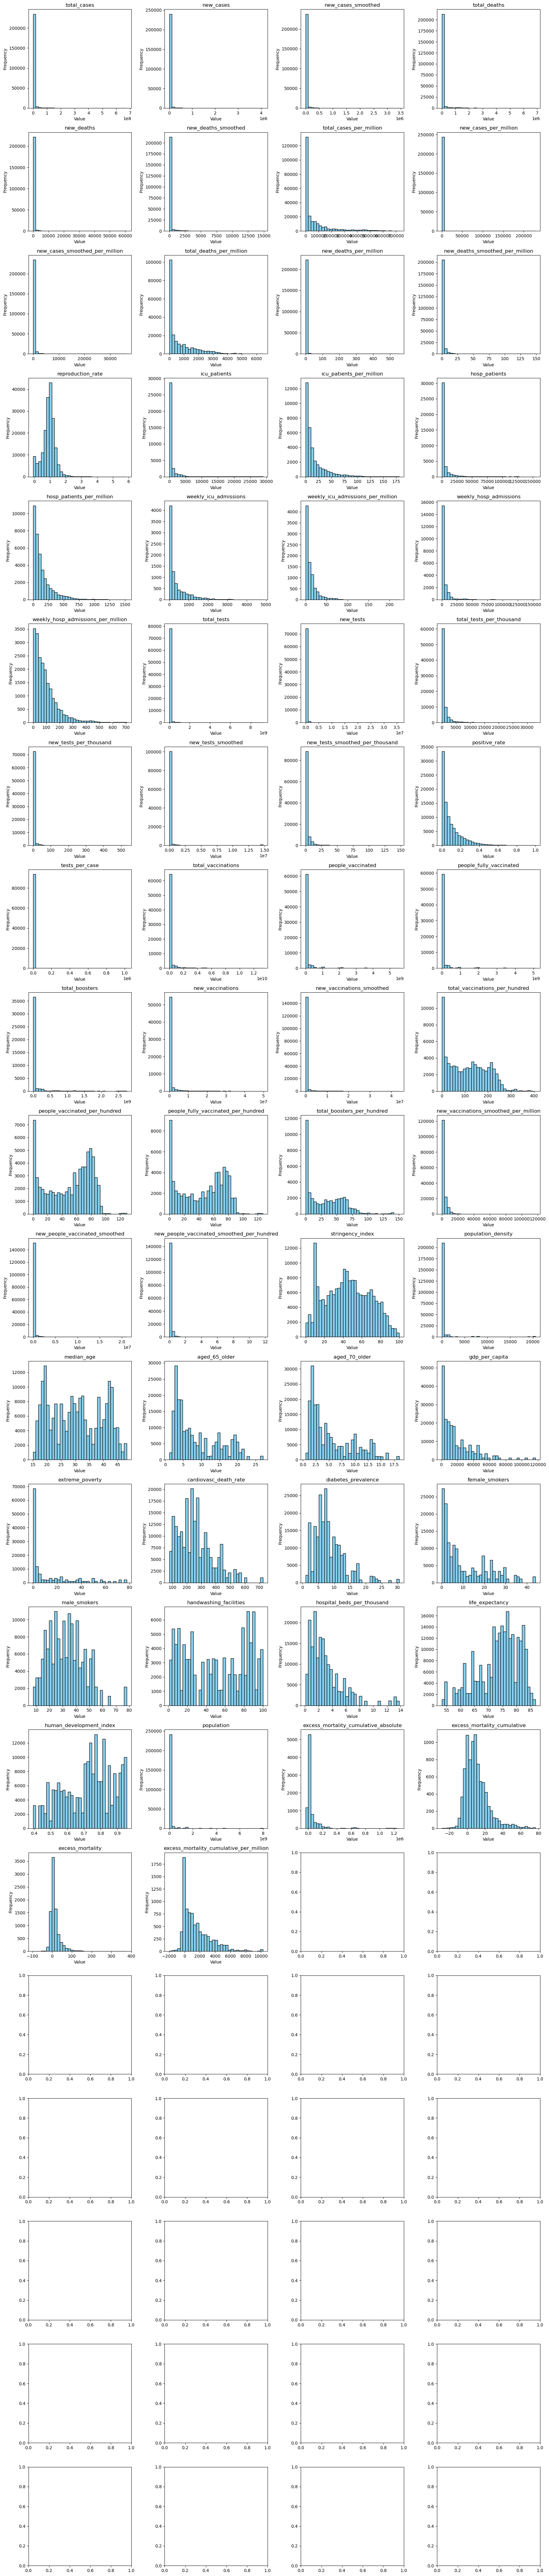

In [1059]:
columns_per_row = 3
num_columns = len(num_data.columns)
num_rows = (num_columns - 1) // columns_per_row + 1
fig_width = 6 * columns_per_row
fig_height = 4 * num_rows
fig, axs = plt.subplots(num_rows, 4, figsize=(fig_width, fig_height))
axs = axs.flatten()
for i, column in enumerate(num_data.columns):
    ax = axs[i]
    ax.hist(num_data[column], bins=35, color='skyblue', edgecolor='black')
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig("../output/Preprocessing/Distributions/distributions_of_variables.png")

### 3. Scaling